In [1]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.4MB/s 


In [0]:
# -*- coding: utf-8 -*-

from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix
import numpy as np
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset, ClassifierChain, BinaryRelevance
from sklearn.svm import SVC
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

class Multilabel:
   def __init__(self, x_train, y_train, x_test, y_test):
      self.x_train = x_train
      self.y_train = y_train
      self.x_test = x_test
      self.y_test = y_test
   
   def plotScores(self,accuracy_res, precision_res, recall_res, f1_res, hamming_res, labels):
      fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(16, 5))

      x = np.arange(len(accuracy_res))
      
      xlabels = list(labels)
      sns.barplot(x, accuracy_res, palette='Blues', ax=ax1)
      sns.barplot(x, precision_res, palette='Reds', ax=ax2)
      sns.barplot(x, recall_res, palette='Greens', ax=ax3)
      sns.barplot(x, f1_res, palette='RdBu_r', ax=ax4)
      sns.barplot(x, hamming_res, palette='coolwarm', ax=ax5)
      
      ax1.set_ylabel('Accuracy')
      ax2.set_ylabel('precision')
      ax3.set_ylabel('Recall')
      ax4.set_ylabel('F1-Score')
      ax5.set_ylabel('Hamming Loss')
      
      # # Add the xlabels to the chart
      ax1.set_xticklabels(xlabels)
      ax2.set_xticklabels(xlabels)
      ax3.set_xticklabels(xlabels)
      ax4.set_xticklabels(xlabels)
      ax5.set_xticklabels(xlabels)
      
      # Add the actual value on top of each bar
      for i, v in enumerate(zip(accuracy_res, precision_res, recall_res,f1_res,hamming_res)):
         ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
         ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
         ax3.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))
         ax4.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))
         ax5.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))
      
      # Show the final plot
      plt.show()

   
   def multilabel_evaluation(self, y_pred, y_test, measurement=None):
      '''
      Micro accuracy, recall, precision, f1_score evaluation
      '''
      
      multilabel_cm = multilabel_confusion_matrix(y_pred, y_test)
      if measurement=='macro':
         tn = np.mean(multilabel_cm[:, 0, 0])
         tp = np.mean(multilabel_cm[:, 1, 1])
         fp = np.mean(multilabel_cm[:, 0, 1])
         fn = np.mean(multilabel_cm[:, 1, 0])
         accuracy = np.around(((tp + tn)/(tn + tp + fn +fp)), 3)
         precision = np.around((tp/(tp + fp)), 3)
         recall = np.around((tp/(tp + fn)), 3)
         f1_score = np.around(2* recall*precision/(recall + precision), 3)
      else:
         tn = multilabel_cm[:, 0, 0]
         tp = multilabel_cm[:, 1, 1]
         fp = multilabel_cm[:, 0, 1]
         fn = multilabel_cm[:, 1, 0]
         ac, p, r = [], [], []
         for i in range(len(tp)):
            ac.append((tp[i] + tn[i])/(tn[i] + tp[i] + fn[i] + fp[i]))
            p.append(0 if tp[i]==0 and fp[i]==0 else tp[i]/(tp[i] + fp[i]))
            r.append(0 if tp[i]==0 and fn[i]==0 else tp[i]/(tp[i] + fn[i]))
      
         accuracy = np.around(np.mean(ac), 3)
         precision = np.around(np.mean(p), 3)
         recall = np.around(np.mean(r), 3)   
         f1_score = np.around(2* recall*precision/(recall + precision), 3)
      hamming = np.around(hamming_loss(y_test, y_pred), 3)
      return {'accuracy':accuracy,
            'precision':precision,
            'recall':recall,
            'f1_score':f1_score,
            'hamming_loss':hamming}

   def oneVsRest(self):
      print("")
      print("Starting One Vs Rest Classifier of sklearn.multiclass...")
      print("")
      start = datetime.now()
      
      pipeline = Pipeline([
                     ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
                  ])
      
      parameters = [
         {
            'clf__estimator__alpha': (0.5, 0.7, 1),
         },
      ]
      
      grid_search_cv = GridSearchCV(pipeline,
                                    parameters,
                                    cv=2,
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)

   def oneVsone(self):
      print("")
      print("Starting One Vs One Classifier of sklearn.multiclass...")
      print("")
      start = datetime.now()
      
      pipeline = Pipeline([
                     ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
                  ])
      
      parameters = [
         {
            'clf__estimator__alpha': (0.5, 0.7, 1),
         }
      ]
      
      grid_search_cv = GridSearchCV(pipeline,
                                    parameters,
                                    cv=2,
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)
   
   def MLkNN(self):
      print("")
      print("Starting MLkNN Classifier of skmultilearn.adapt...")
      print("")
      start = datetime.now()
      
      parameters = {'k': [1,3], 's': [0.7, 1.0]}
      
      grid_search_cv = GridSearchCV(MLkNN(), parameters, scoring='f1_macro',
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)
   
   def LabelPowerset(self):
      print("")
      print("Starting LabelPowerset Classifier of skmultilearn.problem_transform...")
      print("")
      start = datetime.now()
      
      parameters = [
         {
            'classifier': [BernoulliNB()],
            'classifier__alpha': [0.7, 1.0],
         },
         {
            'classifier': [SVC()],
            'classifier__kernel': ['rbf', 'linear'],
         }
      ]
      
      grid_search_cv = GridSearchCV(LabelPowerset(), parameters, scoring='f1_macro',
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)
   
   def ClassifierChain(self):
      print("")
      print("Starting ClassifierChain Classifier of skmultilearn.problem_transform...")
      print("")
      start = datetime.now()
      
      parameters = [
         {
            'classifier': [BernoulliNB()],
            'classifier__alpha': [0.7, 1.0],
         },
         {
            'classifier': [SVC()],
            'classifier__kernel': ['rbf', 'linear'],
         }
      ]
      
      grid_search_cv = GridSearchCV(ClassifierChain(), parameters, scoring='f1_macro',
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)

   def BinaryRelevance(self):
      print("")
      print("Starting BinaryRelevance Classifier of skmultilearn.problem_transform...")
      print("")
      start = datetime.now()
      
      parameters = [
         {
            'classifier': [BernoulliNB()],
            'classifier__alpha': [0.7, 1.0],
         },
         {
            'classifier': [SVC()],
            'classifier__kernel': ['rbf', 'linear'],
         }
      ]
      
      grid_search_cv = GridSearchCV(BinaryRelevance(), parameters, scoring='f1_macro',
                                    verbose=2,
                                    n_jobs=-1)
      grid_search_cv.fit(self.x_train, self.y_train)
      best_clf = grid_search_cv.best_estimator_
      
      print('Finished training in : ', datetime.now()-start) 
      
      y_pred = best_clf.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)

   def MajorityVotingClassifier(self):
      print("")
      print("Starting MajorityVotingClassifier Classifier of skmultilearn.ensemble...")
      print("")
      start = datetime.now()
      
      classifier = MajorityVotingClassifier(
         clusterer = FixedLabelSpaceClusterer(clusters = [[1,2,3], [0, 2, 5], [4, 5]]),
         classifier = ClassifierChain(classifier=GaussianNB())
      )
      
      print('Finished training in : ', datetime.now()-start) 
      
      classifier.fit(self.x_train, self.y_train)
      y_pred = classifier.predict(self.x_test)
      start = datetime.now()
      return self.multilabel_evaluation(y_pred, self.y_test)
      print('Finished classification in : ', datetime.now()-start)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving TweetProcessor.zip to TweetProcessor (1).zip


In [11]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data (1).zip


In [0]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['TweetProcessor.zip']), "r")
zf.extractall()

In [0]:
zf = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), "r")
zf.extractall()

In [13]:
!pip install emoji

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=5d9408784a707747329bbec11e6746d0da73babbc549c59a4c0ca97f5b54c28b
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

from datetime import datetime
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()
start_all = datetime.now()

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def evaluate_model(y_test, y_pred):
   accuracy = np.around(metrics.accuracy_score(y_test, y_pred),3)
   precision = np.around(metrics.precision_score(y_test, y_pred, average='macro'),3)
   recall = np.around(metrics.recall_score(y_test, y_pred, average='macro'),3)
   f1_score = np.around(metrics.f1_score(y_test, y_pred, average='macro'),3)
   print(classification_report(y_test, y_pred))  
   print('accuracy: %s' % accuracy)
   print('precision: %s' % precision)
   print('recall: %s' % recall)
   print('f1_score: %s' % f1_score)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score}

def textblob_sentiment(doc):
   from textblob import TextBlob
   score = TextBlob(doc).sentiment.polarity
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def plot_confusion_matrix(y_test, y_pred):
   from sklearn.preprocessing import MinMaxScaler
   from sklearn.metrics import classification_report, confusion_matrix
   
   labels = np.unique(y_test)
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print(cm_df)
   cmap = sns.color_palette("OrRd", 1000)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def vizualize_classification(y_test, y_pred):
   from sklearn.metrics import classification_report, confusion_matrix
   labels = np.unique(y_test)
   cmap = sns.color_palette("OrRd", 1000)
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
   fig.suptitle('Vizualizing classifier')
   
   ax = sns.countplot(x=y_pred, hue=y_test, order=labels, ax=ax1)
   
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print('Confusion Matrix: \n', cm_df)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g', ax=ax2)
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   evaluate_model(y_test, y_pred)
      
def textblob_NBClassifier(doc):
   blob = TextBlob(doc, classifier=cl)
   return blob.classify()

def multilabel_visualization(values, labels):
   df = pd.DataFrame(data={label:values[:,i] for i, label in enumerate(feelings)})
   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,7))
   fig.suptitle('Class analysis')
   # Label distribution
   df[labels].sum().sort_values(ascending=False).plot(kind='bar', title='Label distribution', ax=ax1)
   # Multiple labels
   sns.countplot(x=df[labels].sum(axis=1), ax=ax2).set_title('Tweets with multiple labels')
   # Word cloud
   # Create target column 'labels'
   df['labels'] = [np.asarray(labels)[i] for i in df[labels].astype('bool').values]
   # Concatenate all labesl together
   words = np.hstack(df['labels'].values)
   # Vizualize label wordcloud
   wc_dict = dict(Counter(words))
   wordcloud = WordCloud(colormap='Blues', 
                         max_font_size=100, 
                         width=300, 
                         height=200).generate_from_frequencies(wc_dict)
   plt.title('Label wordcloud')
   # plt.figure( figsize=(20,10) )

   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
   # correlation visualization
   emotion_corr_heatmap(values, labels=labels)
   
def emotion_corr_heatmap(values, labels=[]):
   if type(values)==pd.DataFrame:
      data = values.corr()
   else:
      data = pd.DataFrame(data=values, columns=labels).corr()
   
   # Generate a mask for the upper triangle
   mask = np.triu(np.ones_like(data, dtype=np.bool))
   cmap = sns.diverging_palette(220, 10, as_cmap=True)
   # Draw the heatmap with the mask and correct aspect ratio
   max_val = np.sort(data, axis=None)[::-1][data.shape[1]]
   ax = sns.heatmap(data, 
               mask=mask, 
               cmap=cmap, 
               center=0,
               square=True, 
               linewidths=.5, 
               cbar_kws={"shrink": .5})
   plt.title('Primitive emotion correlation')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def draw_wordcloud(corpus):
   from wordcloud import WordCloud, STOPWORDS
   from collections import Counter
   from nltk.util import ngrams 
   from nltk.corpus import stopwords
   
   if type(corpus)!=str:
      corpus = ' '.join(corpus).split(' ')
   stop_words = set(list(STOPWORDS) + stopwords.words('english'))
   corpus = [w for w in corpus if w.lower() not in stop_words]
   bigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 2)).most_common()}
   trigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 3)).most_common()}   
   corpus_dict = dict(Counter(corpus).most_common())
   word_count = {**corpus_dict, **bigrams_count, **trigrams_count}
   # draw a Word Cloud with word frequencies
   wordcloud = WordCloud(max_words=50,
                         max_font_size=75,
                         colormap='Pastel2_r',
                        ).generate_from_frequencies(word_count)
   plt.figure(figsize=(10,8))
   plt.title('Wordcloud of unigrams, bigrams, trigrams')
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()

def addValuesToResults(result):
   
   accuracy_res.append(result['accuracy'])
   precision_res.append(result['precision'])
   recall_res.append(result['recall'])
   f1_res.append(result['f1_score'])
   hamming_res.append(result['hamming_loss'])

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

(6838, 13)


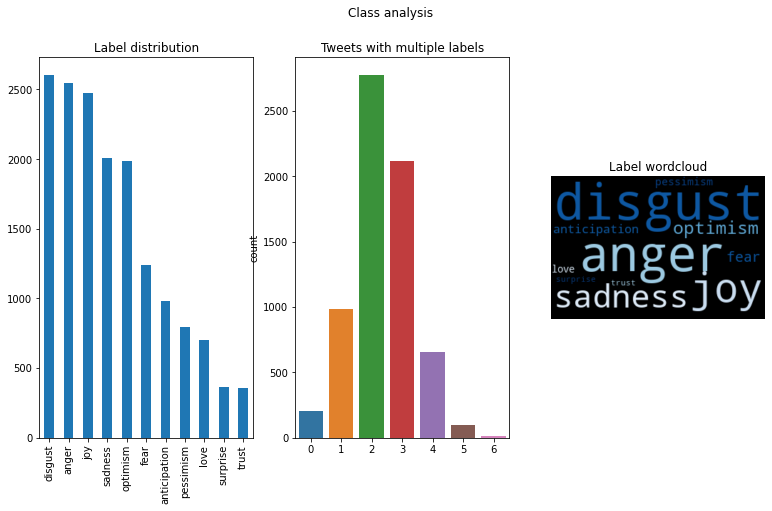

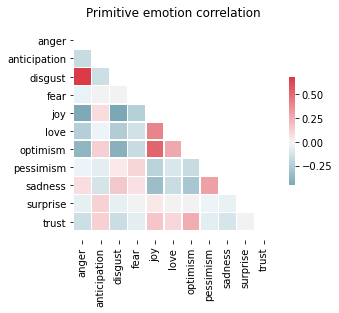

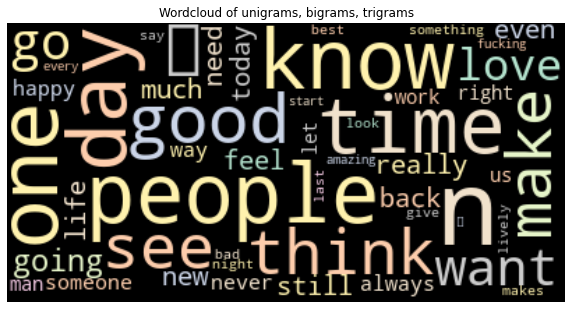

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"



Starting One Vs Rest Classifier of sklearn.multiclass...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.9s finished


Finished training in :  0:00:16.886581

Starting MLkNN Classifier of skmultilearn.adapt...

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 38.9min finished


Finished training in :  0:39:35.038976

Starting LabelPowerset Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 99.4min finished


Finished training in :  1:58:10.187635

Starting ClassifierChain Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 109.5min finished


Finished training in :  2:09:27.724261

Starting BinaryRelevance Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 133.4min finished


Finished training in :  2:35:59.077176

Starting MajorityVotingClassifier Classifier of skmultilearn.ensemble...

Finished training in :  0:00:00.000671


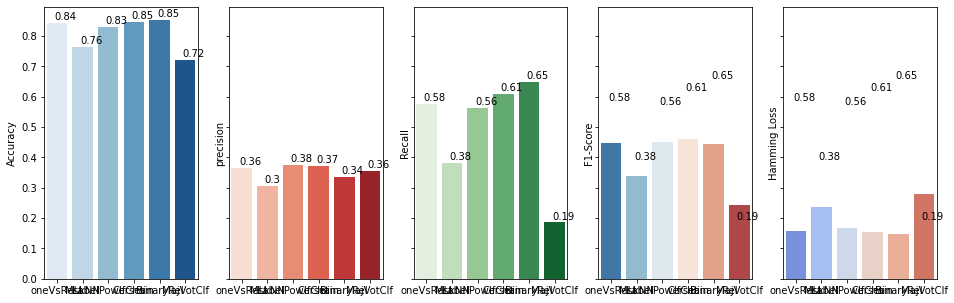

In [18]:
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()

"""## Data exploration

Class distribution
"""

feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_visualization(emo_train_df[feelings].values, feelings)

"""Preprocessing:
* Tokenization
* Stopword removal
* Special character handling
* Emoji parsing
* Data cleaning
"""

emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)

corpus = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x))
draw_wordcloud(corpus)

"""## Feature selection"""

# Tweet preprocessing
emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# LDA features
X_lda = tweet_processor.lda_features(X, len(feelings))

"""Dataset split"""

# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))
y = emo_train_df[feelings].values
x_train_id, x_test_id, y_train, y_test = train_test_split(range(X_combined.shape[0]), y, test_size=0.2, random_state=0)
x_train, x_test = X_combined[x_train_id], X_combined[x_test_id]
x_train.shape, y_train.shape, x_test.shape

Multilabel = Multilabel(x_train, y_train, x_test, y_test)

accuracy_res = []
precision_res = []
recall_res = []
f1_res = []
hamming_res = []
labels = []

results = Multilabel.oneVsRest()
addValuesToResults(results)
labels.append("oneVsRest")

results = Multilabel.MLkNN()
addValuesToResults(results)
labels.append("MLkNN")

results = Multilabel.LabelPowerset()
addValuesToResults(results)
labels.append("LabelPowerset")

results = Multilabel.ClassifierChain()
addValuesToResults(results)
labels.append("ClfChain")

results = Multilabel.BinaryRelevance()
addValuesToResults(results)
labels.append("BinaryRel")

results = Multilabel.MajorityVotingClassifier()
addValuesToResults(results)
labels.append("MajVotClf")

Multilabel.plotScores(accuracy_res, precision_res, recall_res, f1_res, hamming_res, labels)